In [2]:
import scyan
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import anndata
%matplotlib inline
import re 
from pathlib import Path
## Run w/ scyan conda environment 

/stor/home/jfm2773/anaconda3/envs/scyan_GPU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


## Functions

In [6]:
def combine_image_data(image_dir):
    csv_paths      = [csv_path for csv_path in Path(image_dir).rglob('*_mask.csv*')]
    mask_df_list   = [None] * len(csv_paths)

    for i in range(0, len(csv_paths)):
        csv_path = csv_paths[i]
        mask_df_list[i] = pd.read_csv(csv_path)
        mask_df_list[i]["experiment"] = str(csv_path)

    combined_mask_df = pd.concat(mask_df_list, axis= 0)
    codes, uniques = pd.factorize(combined_mask_df.experiment)
        ## uniques is what I'll need to identify which cluster is which experiment later
    combined_mask_df.experiment = codes
    
    data_dir= os.path.join(image_dir, "data")
    if not os.path.exists(data_dir):
            os.makedirs(data_dir)
    combined_mask_path = os.path.join(data_dir, "combined_mask_df.csv")
    combined_mask_df.to_csv(combined_mask_path, index= False)
    experiment_dummy = pd.DataFrame({"experiment" : np.unique(codes),
                                    "exp_name"    : uniques})
    experiment_dummy.to_csv(os.path.join(data_dir, "experiment_dummy.csv"), index= False)

    return(combined_mask_df)


def convert_df_to_adata(df, marker_list):
    adata = anndata.AnnData(df)
    adata.obs = adata[:, ["CellID", "X_centroid", "Y_centroid", "experiment"]].to_df()
    adata = adata[:, marker_list]
                       
    print(f"Created anndata object with {adata.n_obs} cells and {adata.n_vars} markers.\n\n-> The markers names are: {', '.join(adata.var_names)}\n-> The non-marker names are: {', '.join(adata.obs.columns)}")

    return(adata)

def preprocess_scyan(adata, is_cytof):
    if is_cytof:
        scyan.preprocess.asinh_transform(adata)
    else: #
        scyan.preprocess.auto_logicle_transform(adata)
            ## Some transformation designed for flow: https://pubmed.ncbi.nlm.nih.gov/16604519/
    scyan.preprocess.scale(adata)
    return(adata)


def full_scyan_pipeline(image_dir, knowledge_table_path, num_workers, is_cytof = False):
     ## Making data
     knowledge_table = pd.read_csv(knowledge_table_path)

     combined_mask_df = combine_image_data(image_dir = image_dir)
     adata = convert_df_to_adata(df= combined_mask_df, marker_list= knowledge_table.columns.to_list())
     adata = preprocess_scyan(adata = adata, is_cytof = is_cytof)


     ## Running Scyan
     model = scyan.Scyan(adata, knowledge_table)
     model.fit(num_workers= num_workers)
     model.predict()


     ## Plotting data
     scyan.tools.umap(adata, markers= knowledge_table.columns)
     scyan.plot.umap(adata, color= "scyan_pop", title= "Scyan predictions")
     
     print(adata.obs.scyan_pop.value_counts())
     print(adata.obs.scyan_pop.value_counts(normalize= True))

     scatter_plot = scyan.plot.scatter(adata, 
                                      population = None, 
                                      markers    = knowledge_table.columns.to_list())
     scatter_plot.savefig(os.path.join(image_dir,"scyan_scatter_plot.jpg"))   
     plt.close(scatter_plot) 

     pop_expression = scyan.plot.pops_expressions(model, 
                                                 latent  = True, 
                                                 figsize = (10, 6))
     pop_expression.savefig(os.path.join(image_dir,"scyan_pop_expression.jpg"))   
     plt.close(pop_expression)

     ## Write output
     adata.obs.to_csv(os.path.join(image_dir, "data/combined_mask_df_scyan_obs.csv"), index= False)
     pd.DataFrame(adata.X, columns = adata.var_names).to_csv(os.path.join(image_dir, "data/combined_mask_df_scyan_X.csv"),index= False)


## Add scyan extra visualization functions

## I should go through at some point and do type hinting

In [3]:
## Testing saving plotting functions

adata, table = scyan.data.load("aml") # Automatic loading
model = scyan.Scyan(adata, table)
model.fit(num_workers = 1)
model.predict()

[INFO] (scyan.model) Initialized Scyan model with N=104184 cells, P=14 populations and M=14 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False
[INFO] (scyan.model) Training scyan with the following hyperparameters:
"batch_key":       None
"batch_size":      8192
"hidden_size":     16
"lr":              0.0005
"max_samples":     200000
"modulo_temp":     3
"n_hidden_layers": 6
"n_layers":        7
"prior_std":       0.3
"temperature":     0.5

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
GPU available: True (cuda), used: False
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/s

Epoch 22: 100%|██████████| 12/12 [02:32<00:00, 12.71s/it, loss=13.8]

[INFO] (scyan.model) Successfully ended traning.


DataLoader: 100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


0                pDCs
1           Basophils
2                pDCs
3           Basophils
4           Basophils
             ...     
104179    Pro B cells
104180    Pre B cells
104181    Pro B cells
104182    Pro B cells
104183    Pre B cells
Length: 104184, dtype: category
Categories (14, object): ['Basophils', 'CD16+ NK cells', 'CD16- NK cells', 'CD34+CD38+CD123+ HSPCs', ..., 'Plasma B cells', 'Pre B cells', 'Pro B cells', 'pDCs']

DataLoader: 100%|██████████| 13/13 [00:53<00:00,  4.08s/it]


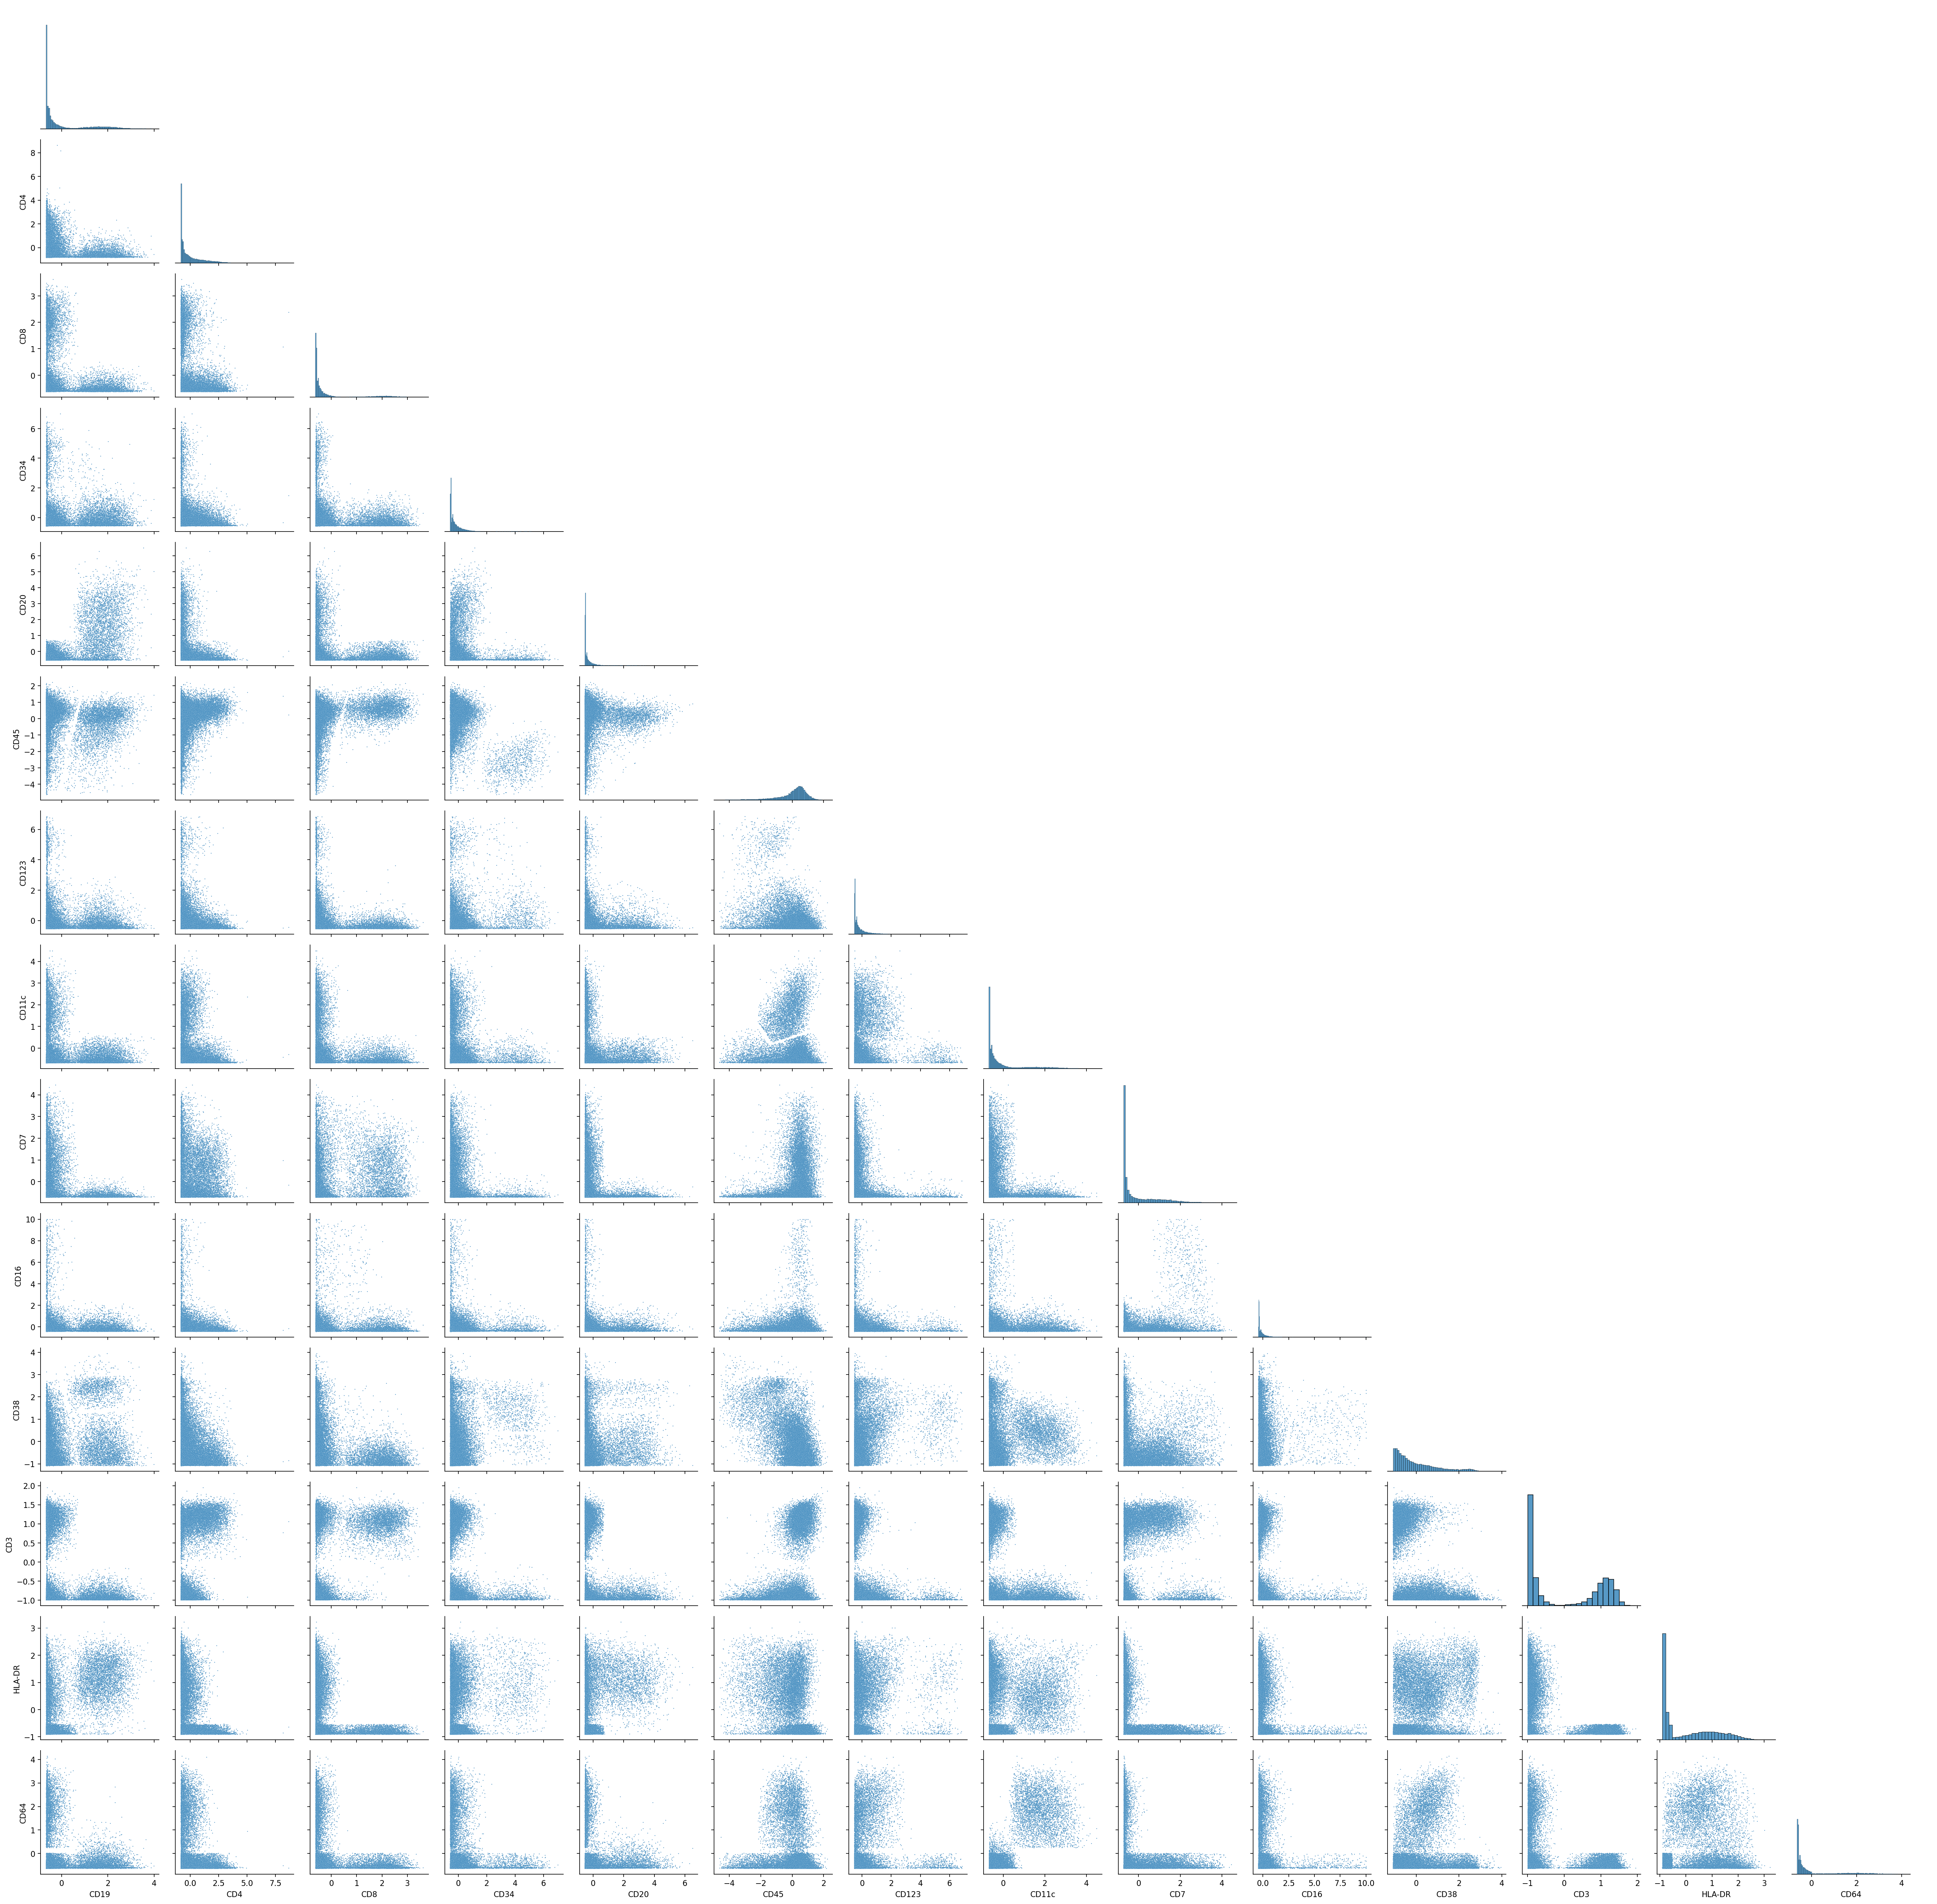

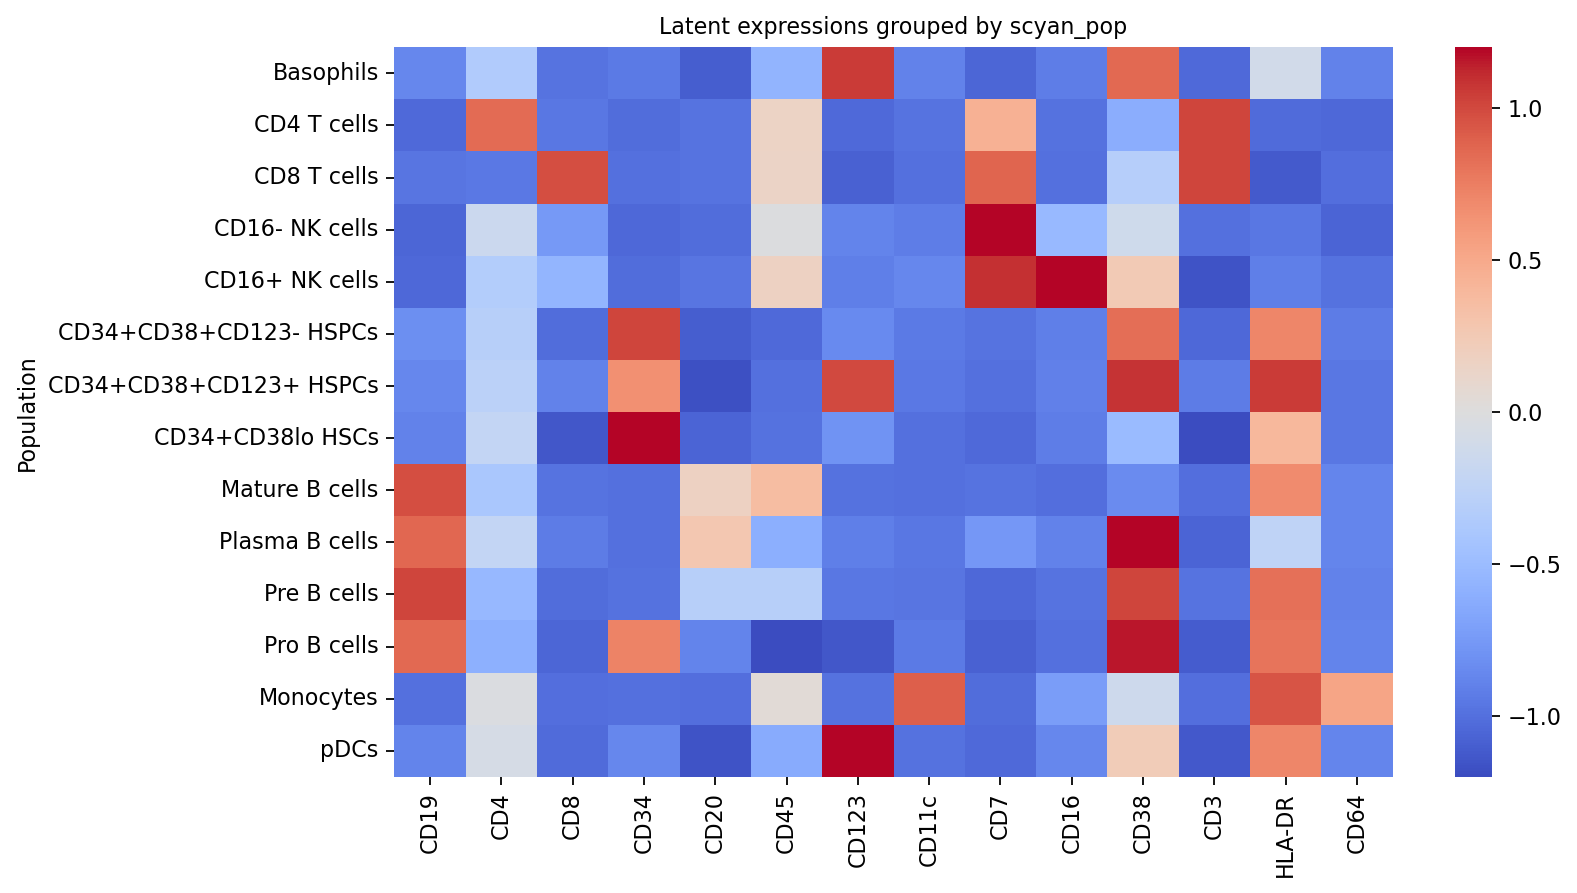

In [8]:
image_dir= "/stor/work/Ehrlich/Users/John"
scyan.plot.scatter(adata, 
                                  population = None, 
                                      markers    = table.columns.to_list(), 
                                      show= False)
plt.savefig(os.path.join(image_dir,"scyan_scatter_plot.jpg"))   


scyan.plot.pops_expressions(model, 
                                                 latent  = True, 
                                                 figsize = (10, 6), 
                                                 show    = False)
plt.savefig(os.path.join(image_dir,"scyan_pop_expression.jpg"))   

In [5]:
model = scyan.Scyan(adata, table)
model.fit(num_workers = 2)
## It fails with multiple workers.
## I also couldn't get it to work with GPUs by changing the internal commands. 
model.predict()

## This runs in 40 minutes with num_workers = 1 
## Fails with num_workers = 2 
    ## This is an easy reprex. 

[INFO] (scyan.model) Initialized Scyan model with N=104184 cells, P=14 populations and M=14 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False
[INFO] (scyan.model) Training scyan with the following hyperparameters:
"batch_key":       None
"batch_size":      8192
"hidden_size":     16
"lr":              0.0005
"max_samples":     200000
"modulo_temp":     3
"n_hidden_layers": 6
"n_layers":        7
"prior_std":       0.3
"temperature":     0.5

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/stor/home/jfm2773/anaconda3/envs/scyan_GPU/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=8)`.
  rank_zero_warn(

  | Name   | Type        | Params
---------------------------------------
0 | mod

Epoch 0:   0%|          | 0/12 [00:00<?, ?it/s] 

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 193, in __getitem__
    return tuple(tensor[index] for tensor in self.tensors)
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 193, in <genexpr>
    return tuple(tensor[index] for tensor in self.tensors)
IndexError: index 258794944 is out of bounds for dimension 0 with size 104184


## Running w/ T cell zone images

In [7]:
## Making knowledge table 
TCZ_table= pd.DataFrame(data= {
    "B220"        : [-1, -1, 1],
    "CD4"         : [1, np.nan, -1],
    "CD8"         : [np.nan, 1, -1]
}, 
index= ["CD4SP", "CD8SP", "Bcell"])
date = "2023-05-18"
TCZ_table_path = os.path.join("/stor/scratch/Ehrlich/Users/John/CCR4/T_cell_zone/data/knowledge_tables", "Tcell_zone_table_" + date + ".csv")
TCZ_table.to_csv(TCZ_table_path, index= False)

TCZ_table

B220  CD4  CD8
CD4SP    -1  1.0  NaN
CD8SP    -1  NaN  1.0
Bcell     1 -1.0 -1.0

In [8]:
full_scyan_pipeline(image_dir            = "/stor/scratch/Ehrlich/Users/John/CCR4/T_cell_zone", 
                    knowledge_table_path = TCZ_table_path,
                    num_workers          = 30)
    ## num_workers parallelizes the training into individual jobs

/stor/home/jfm2773/anaconda3/envs/scyan_GPU/lib/python3.10/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/tmp/ipykernel_3620421/3782695141.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(df)
/stor/home/jfm2773/anaconda3/envs/scyan_GPU/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/stor/home/jfm2773/anaconda3/envs/scyan_GPU/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.

Created anndata object with 674573 cells and 3 markers.

-> The markers names are: B220, CD4, CD8
-> The non-marker names are: CellID, X_centroid, Y_centroid, experiment


[WARNING] (scyan.preprocess) Auto logicle transformation failed for the following markers (logicle was used instead): B220, CD4, CD8.
It can happen when expressions are all positive or all negative.
[INFO] (scyan.preprocess) Data will be centered and standardised. This is advised only when using spectral/flow data (if this is not your case, consider running 'asinh_transform' instead of 'auto_logicle_transform').
[INFO] (scyan.model) Initialized Scyan model with N=674573 cells, P=3 populations and M=3 markers.
   ├── No covariate provided
   ├── No continuum-marker provided
   └── Batch correction mode: False
[INFO] (scyan.model) Training scyan with the following hyperparameters:
"batch_key":       None
"batch_size":      8192
"hidden_size":     16
"lr":              0.0005
"max_samples":     200000
"modulo_temp":     3
"n_hidden_layers": 6
"n_layers":        7
"prior_std":       0.3
"temperature":     0.5

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
GPU available: Tr

Epoch 0:   0%|          | 0/24 [00:00<?, ?it/s] 

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 193, in __getitem__
    return tuple(tensor[index] for tensor in self.tensors)
  File "/stor/home/jfm2773/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 193, in <genexpr>
    return tuple(tensor[index] for tensor in self.tensors)
IndexError: index 236305728 is out of bounds for dimension 0 with size 674573


## Running w/ max_membrane_masks 

In [3]:
## Making knowledge table 
MMM_table= pd.DataFrame(data= {
    "CD63"        : [1, -1],
    "CD11c"       : [np.nan, -1],
    "Sirpa"       : [1, 1]
}, 
index= ["aDC2", "cDC2"])
date = "2023-05-18"
MMM_table_path = os.path.join("/stor/scratch/Ehrlich/Users/John/histocytometry/processed_images/gb5/data/knowledge_tables", 
                              "40x_Cortex_DAPI_CD63_CD11c_Sirpa_" + date + ".csv")
MMM_table.to_csv(MMM_table_path, index= False)

MMM_table

CD63  CD11c  Sirpa
aDC2     1    NaN      1
cDC2    -1   -1.0      1

In [4]:
full_scyan_pipeline(image_dir            = "/stor/scratch/Ehrlich/Users/John/histocytometry/processed_images/gb5/40x_Cortex_DAPI_CD63_CD11c_Sirpa/max_membrane_mask", 
                    knowledge_table_path = MMM_table_path,
                    num_workers          = 30)

/stor/home/jfm2773/anaconda3/envs/scyan_GPU/lib/python3.10/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/tmp/ipykernel_2889291/4159613348.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(df)


KeyError: "Values ['CD63', 'CD11c', 'Sirpa'], from ['CD63', 'CD11c', 'Sirpa'], are not valid obs/ var names or indices."